# Resolución de problemas de optimización combinatoria utilizando QAOA

En este tutorial, presentamos problemas de optimización combinatoria, explicamos algoritmos de optimización aproximada, explicamos cómo funciona el Algoritmo Cuántico de Optimización Aproximada (Quantum Approximate Optimization Algorithm, QAOA) y presentamos la implementación de un ejemplo que se puede ejecutar en un simulador o en un sistema cuántico real.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

## Problema de Optimización Combinatoria

Los problemas de optimización combinatoria implican encontrar un objeto óptimo a partir de un conjunto finito de objetos. Nos centraríamos en problemas que impliquen encontrar cadenas de bits "óptimas" compuestas de 0s y 1s entre un conjunto finito de cadenas de bits. Uno de esos problemas correspondientes a un grafo es el problema de Max-Cut (máximo corte).

### Problema Max-Cut

Un problema de Max-Cut (máximo corte) implica dividir los nodos de un grafo en dos conjuntos, de modo que el número de aristas entre los conjuntos sea el máximo. El siguiente ejemplo tiene un grafo con cuatro nodos y se muestran algunas de las formas en que se puede dividir en dos conjuntos, "rojo" y "azul".

![](images/qaoa_maxcut.svg)

Para 4 nodos, como cada nodo se puede asignar a los conjuntos "rojo" o "azul", hay $2^4=16$ asignaciones posibles, de las cuales tenemos que encontrar una que proporcione el máximo número de aristas entre los conjuntos "rojo" y "azul". El número de tales aristas entre dos conjuntos en la figura, a medida que avanzamos de izquierda a derecha, son 0, 2, 2 y 4. Podemos ver, después de enumerar todas las asignaciones posibles de $2^4=16$, que la figura más a la derecha es la asignación que da el número máximo de aristas entre los dos conjuntos. Por lo tanto, si codificamos "rojo" como 0 y "azul" como 1, las cadenas de bits "0101" y "1010" que representan la asignación de nodos a cualquiera de los conjuntos son las soluciones. 

Como te habrás dado cuenta, a medida que aumenta la cantidad de nodos en el grafo, la cantidad de asignaciones posibles que debes examinar para encontrar la solución aumenta exponencialmente.

## QAOA

QAOA (Algoritmo Cuántico de Optimización Aproximada) presentado por Farhi et al.[1] es un algoritmo cuántico que intenta resolver este tipo de problemas combinatorios.<br>

Es un algoritmo variacional que utiliza una unitaria $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ caracterizada por los parámetros $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ para preparar un estado cuántico $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$. El objetivo del algoritmo es encontrar parámetros óptimos `{latex} (\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}})` tales que el estado cuántico `{latex} \lvert \psi(\boldsymbol{\beta}_{\text{opt}}, \boldsymbol{\gamma}_{\text{opt}}) \rangle` codifique la solución al problema.

La unitaria $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ tiene una forma específica y está compuesta por dos unitarias $U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ y $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$ donde $H_B$ es el Hamiltoniano de mezcla y $H_P$ es el Hamiltoniano del problema. Tal elección de unitarias se inspira en un esquema relacionado llamado recocido cuántico (quantum annealing).

El estado se prepara aplicando estas unitarias como bloques alternos de las dos unitarias aplicadas $p$ veces tal que

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma}) \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p ; \text{times}} \lvert \psi_0 \rangle$$

donde $\lvert \psi_0 \rangle$ es un estado inicial adecuado.

Demostraremos estos pasos usando el problema Max-Cut discutido anteriormente. Para eso, primero definiríamos el grafo subyacente del problema que se muestra arriba.

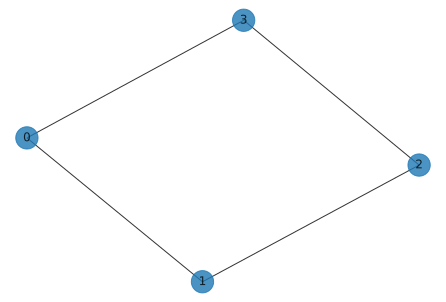

In [2]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

El Hamiltoniano del problema específico del problema Max-Cut hasta una constante aquí es:

$$ H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) + \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) + \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) + \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big) $$

Para construir un Hamiltoniano de este tipo para un problema, es necesario seguir algunos pasos que cubriremos en secciones posteriores de esta página.

El Hamiltoniano mezclador $H_B$ suele tener la forma:

$$ H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) + \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) + \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) + \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big) $$

Como términos individuales en la suma de $H_P$ y $H_B$ ambos conmutan, podemos escribir las unitarias como:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

Ten en cuenta que cada término en el producto anterior corresponde a una rotación X en cada qubit. Y podemos escribir $U(H_P)$ como:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

Examinemos ahora cómo se ven los circuitos de las dos unitarias. 

### La Unitaria Mezcladora

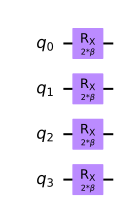

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# La adjacency es esencialmente una matriz que te dice qué nodos están
# conectados. Esta matriz se da como una matriz dispersa, por lo que debemos
# convertirla en una matriz densa
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

### El Problema de la Unitaria

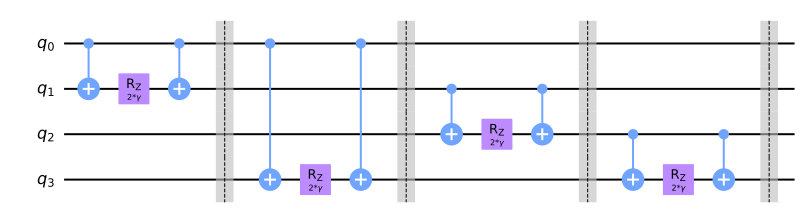

In [4]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pares de nodos
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

### El Estado Inicial

El estado inicial utilizado durante QAOA suele ser una superposición igual de todos los estados básicos, es decir,

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

Dicho estado, cuando el número de qubits es 4 ($n=4$), se puede preparar aplicando compuertas Hadamard a partir de un estado totalmente cero, como se muestra en el siguiente circuito. 

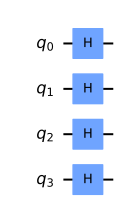

In [5]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

### El circuito QAOA

Hasta ahora hemos visto que la preparación de un estado cuántico durante QAOA se compone de tres elementos

- Preparar un estado inicial
- Aplicar la unitaria `{latex} U(H_P) = e^{-i \gamma H_P}` correspondiente al Hamiltoniano del problema
- Luego, aplicar la mezcla unitaria `{latex} U(H_B) = e^{-i \beta H_B}`

Veamos cómo se ve para el problema de ejemplo:

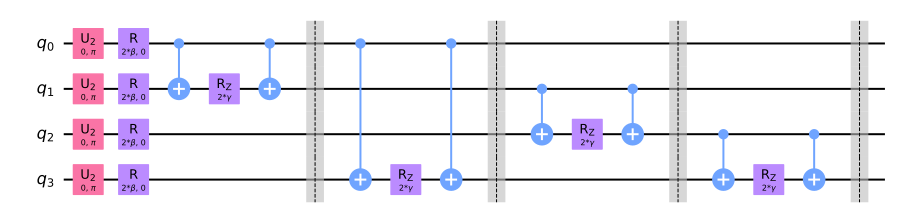

In [6]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

El siguiente paso es encontrar los parámetros óptimos `{latex} (\boldsymbol{\beta_{\text{opt}}}, \boldsymbol{\gamma_{\text{opt}}})` tales que el valor esperado

$$ \langle \psi(\boldsymbol{\beta}*{\text{opt}}, \boldsymbol{\gamma}*{\text{opt}}) \rvert H_P \lvert \psi(\boldsymbol{\beta}*{\text{opt}}, \boldsymbol{\gamma}*{\text{opt}}) \rangle $$

se minimiza. Tal expectativa se puede obtener al hacer la medición en la base Z. Usamos un algoritmo de optimización clásico para encontrar los parámetros óptimos. Los siguientes pasos están involucrados como se muestra en el esquema.

<img src="images/QAOA_schematic.png" width="400" height="200" class="center">

1. Inicializa $\boldsymbol{\beta}$ y $\boldsymbol{\gamma}$ con valores reales adecuados.
2. Repite hasta que se cumplan algunos criterios de convergencia adecuados:
    1. Preparar el estado $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ usando el circuito qaoa
    2. Medir el estado en la base estándar
    3. Calcular $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $
    4. Encontrar un nuevo conjunto de parámetros `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})` usando un algoritmo de optimización clásico
    5. Establecer los parámetros actuales $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ iguales a los nuevos parámetros `{latex} (\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})`

El siguiente código implementa los pasos mencionados anteriormente.

In [7]:
def maxcut_obj(x, G):
    """
    Dada una cadena de bits como solución, esta función devuelve
    el número de aristas compartidas entre las dos particiones
    del grafo.
    
    Args:
        x: str
           cadena de bits de la solución
           
        G: grafo networkx
        
    Returns:
        obj: float
             Objectivo
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Calcula el valor esperado en función de los resultados 
    de la medición
    
    Args:
        counts: dict
                key como la cadena de bits, val como el conteo
           
        G: grafo networkx
        
    Returns:
        avg: float
             valor esperado
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# También traeremos los diferentes componentes del circuito
# que construyen el circuito qaoa bajo una sola función
def create_qaoa_circ(G, theta):
    
    """
    Crea un circuito qaoa parametrizado
    
    Args:  
        G: grafo networkx
        theta: list
               parámetros unitarios
                     
    Returns:
        qc: circuito qiskit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # número de unitarias alternas
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problema unitario
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mezclador unitario
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finalmente escribimos una función que ejecuta el circuito en el backend elegido
def get_expectation(G, p, shots=512):
    
    """
    Ejecuta el circuito parametrizado
    
    Args:
        G: grafo networkx
        p: int,
           Número de repeticiones de las unitarias
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [8]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 30
  status: 1
 success: True
       x: array([1.9793337 , 1.16663483])

Observa que qiskit presenta diferentes opciones de optimizadores clásicos. Aquí elegimos [COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py) como nuestro algoritmo de optimización clásico.

### Analizando el resultado

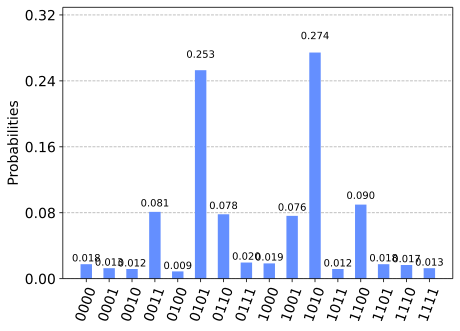

In [9]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

Como notamos que las cadenas de bits "0101" y "1010" tienen la probabilidad más alta y, de hecho, son las asignaciones del grafo (con el que empezamos) que da 4 aristas entre las dos particiones. 

## Apéndice

### 1. Construcción del Hamiltoniano del Problema <a id="Constructing Hamiltonian"></a>

Cualquier problema de maximización puede expresarse en términos de un problema de minimización y viceversa. Por lo tanto, la forma general de un problema de optimización combinatoria viene dada por

$$ \text{maximizar } ;;      C(x)$$

$$ \text{sujeto a } ;; x \in S $$

donde $x \in S$, es una variable discreta y $C : D \rightarrow \mathbb{R}$ es la función de costo, que mapea desde algún dominio $S$ a los números reales $\mathbb{R}$. La variable $x$ puede estar sujeta a un conjunto de restricciones y se encuentra dentro del conjunto $S \subset D$ de puntos factibles.

En los problemas de optimización combinatoria binaria, la función de costo $C$ generalmente se puede expresar como una suma de términos que solo involucran un subconjunto $Q \subset[n]$ de los $n$ bits en la cadena $x \in {0,1}^n$ y está escrito en la forma canónica

$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} ; \prod_{i\in Q} x_i ; \prod_{j\in \overline{Q}} (1- x_j), $$

donde  $x_i \in {0,1}$ y $w_{(Q,\overline{Q})}\in \mathbb{R}$. Queremos encontrar la cadena de n bits $x$ para la cual $C(x)$ es el máximo.

#### 1.1 Hamiltonianos Diagonales

Esta función de costo se puede mapear a un Hamiltoniano que es diagonal en la base computacional. Dada la función de costo $C$, este Hamiltoniano se escribe como

$$ H = \sum_{x \in {0,1}^n} C(x) |x \rangle\langle x| $$

donde $x \in {0,1}^n$ etiqueta los estados de la base computacional $|x \rangle \in \mathbb{C}^{2^n}$. Si la función de costo solo tiene como máximo $k$ términos de peso, es decir, cuando solo contribuye $Q$ que involucra como máximo $Q \leq k$ bits, entonces este Hamiltoniano diagonal también es solo una suma de operadores Pauli con ponderación $k$.

La expansión de $H$ en operadores de Pauli $Z$ se puede obtener a partir de la expansión canónica de la función de costo $C$ sustituyendo cada variable binaria $x_i \in {0,1}$ por la matriz `{latex} x_i \rightarrow 2^{-1}(1 - Z_i)`. Aquí $Z_i$ se lee como el operador de Pauli $Z$ que actúa sobre el qubit $i$ y es trivial sobre todos los demás, es decir

$$ Z_i = \left(\begin{array}{cc} 1 &amp; 0 \ 0 &amp; -1 \end{array}\right). $$

Esto significa que el Hamiltoniano de espín que codifica la función de costo clásica se escribe como $|Q|$, Hamiltoniano de espín cuántico local que solo involucra a los operadores Pauli $Z$.

$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} ; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) ; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$

Ahora, supondremos que solo unos pocos (polinomialmente muchos en $n$) $w_{(Q,\overline{Q})}$ serán distintos de cero. Además, supondremos que el conjunto $|(Q,\overline{Q})|$ está acotado y no es demasiado grande. Esto significa que podemos escribir la función de costo así como el Hamiltoniano $H$ como la suma de $m$ términos locales $\hat{C}_k$,

$$ H = \sum_{k = 1}^m \hat{C}_k, $$

donde tanto $m$ como el soporte de $\hat{C}_k$ están razonablemente acotados.

### 2 Ejemplos: <a id="examples"></a>

Consideramos 2 ejemplos para ilustrar problemas de optimización combinatoria. Solo implementaremos el primer ejemplo en Qiskit, pero proporcionaremos una secuencia de ejercicios que dan las instrucciones para implementar el segundo ejemplo también.

#### 2.1 $MAXCUT$ (ponderado)

Considera un grafo no dirigido de $n$ nodos *G = (V, E)* donde *|V| = n* con pesos de arista $w_{ij}&gt;0$, `{latex} w_{ij}=w_{ji}`, para $(i,j)\in E$. Un corte se define como una partición del conjunto original V en dos subconjuntos. La función de costo a optimizar es en este caso es la suma de los pesos de los puntos de conexión de las aristas en los dos subconjuntos diferentes, *cruzando* el corte. Al asignar $x_i=0$ o $x_i=1$ a cada nodo $i$, se intenta maximizar la función de ganancia global (aquí y en las siguientes sumas sobre los índices 1,2,...,n)

$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$

Para simplificar la notación, asumimos pesos uniformes $ w_{ij} = 1$ para $(i,j) \in E$. Para encontrar una solución a este problema en una computadora cuántica, primero es necesario mapearlo a un Hamiltoniano diagonal como se discutió anteriormente. Escribimos la suma sobre aristas en el conjunto $E$

$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$

Para mapearlo a un Hamiltoniano de espín, hacemos la asignación `{latex} x_i\rightarrow (1-Z_i)/2`, donde $Z_i$ es el operador Pauli Z que tiene valores propios $\pm 1$ y obtenemos $C(\textbf{x}) \rightarrow H$

$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$

Esto significa que el Hamiltoniano se puede escribir como una suma de $m = |E|$ términos locales:

$$\hat{C}*e = \frac{1}{2}\left(1 - Z*<e>Z_<e>\right)$$</e></e>

con $e = (e1,e2) \in E$.

#### 2.2 Problemas de satisfacción de restricciones y $\text{MAX 3-SAT}$.

Otro ejemplo de un problema de optimización combinatoria es $\text{3-SAT}$. Aquí la función de costo `{latex} C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})` es una suma de cláusulas $c_k(\textbf{x})$ que restringen los valores de $3$ bits de algunas $\textbf{x} \in {0,1}^n$ que participan en la cláusula. Considera, por ejemplo, este caso de una cláusula $\text{3-SAT}$

$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$

para una cadena de bits $\textbf{x} \in {0,1}^{133}$. La cláusula solo puede cumplirse configurando los bits $x_1 = 0$, $x_3 = 0$ y $x_{132} = 1$. El problema $\text{3-SAT}$ ahora pregunta si hay una cadena de bits que satisfaga todas las cláusulas $m$ o si no existe tal cadena. Este problema de decisión es el principal ejemplo de un problema que es $NP$ completo.

El problema de optimización estrechamente relacionado $\text{MAX 3-SAT}$ pide encontrar la cadena de bits $\textbf{x}$ que satisface el número máximo de cláusulas en $C(\textbf{x})$. Por supuesto, esto puede convertirse nuevamente en un problema de decisión si preguntamos dónde existe una cadena de bits que satisface más de $\tilde{m}$ de las $m$ cláusulas, que nuevamente es $NP$ completo.

### 3. Algoritmos de optimización aproximada <a id="approximateOPT"></a>

Tanto los problemas considerados anteriormente $MAXCUT$ como $\text{MAX 3-SAT}$ son en realidad problemas NP-difíciles (NP-hard) [3](#references). De hecho, resulta que muchos problemas de optimización combinatoria son computacionalmente difíciles de resolver en general. A la luz de este hecho, no podemos esperar encontrar un algoritmo demostrablemente eficiente, es decir, un algoritmo con tiempo de ejecución polinomial en el tamaño del problema, que resuelva estos problemas. Esto también se aplica a los algoritmos cuánticos. Hay dos enfoques principales para tratar estos problemas. El primer enfoque son los algoritmos de aproximación que están garantizados para encontrar una solución de calidad específica en tiempo polinomial. El segundo enfoque son los algoritmos heurísticos que no tienen una garantía de tiempo de ejecución polinomial pero parecen funcionar bien en algunos casos de tales problemas.

Los algoritmos de optimización aproximada son eficientes y brindan una garantía comprobable de qué tan cerca está la solución aproximada del óptimo real del problema. La garantía generalmente se presenta en forma de una relación de aproximación, $\alpha \leq 1$. Un algoritmo de optimización aproximada probabilística garantiza que produce una cadena de bits $\textbf{x}^* \in {0,1}^n$ de modo que *con alta probabilidad* tenemos que con un `{latex} C_\text{max} = \max_{\textbf{x}}C(\textbf{x})` positivo

$$ C_\text{max} \geq C(\textbf{x}^*) \geq \alpha C_\text{max}. $$

Para el problema de $MAXCUT$ existe un famoso algoritmo aproximado debido a Goemans y Williamson [2](#references). Este algoritmo se basa en una relajación SDP del problema original combinada con una técnica de redondeo probabilístico que arroja una solución aproximada de alta probabilidad $\textbf{x}^*$ que tiene una relación de aproximación de $\alpha \approx 0.878$. En realidad, se cree que esta relación de aproximación es óptima, por lo que no esperamos ver una mejora mediante el uso de un algoritmo cuántico.

### 4. El algoritmo QAOA <a id="QAOA"></a>

El algoritmo de optimización aproximada cuántica (Quantum Approximate Optimization Algorithm, QAOA) de Farhi, Goldstone y Gutmann [1](#references) es un ejemplo de algoritmo heurístico. A diferencia del algoritmo de Goemans-Williamson, QAOA no viene con garantías de rendimiento. QAOA adopta el enfoque de los algoritmos aproximados clásicos y busca un análogo cuántico que también produzca una cadena de bits clásica $x^*$ que, con alta probabilidad, se espera que tenga una buena relación de aproximación $\alpha$. Antes de discutir los detalles, primero presentemos la idea general de este enfoque.

#### 4.1 Descripción general:

Queremos encontrar un estado cuántico $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$, que depende de unos parámetros reales $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$, que tiene la propiedad de maximizar el valor esperado con respecto al Hamiltoniano del problema $H$. Dado este estado de prueba, buscamos parámetros $\vec{\gamma}^*,\vec{\beta}^*$ que maximicen `{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle`.

Una vez que tenemos dicho estado y los parámetros correspondientes, preparamos el estado $|\psi_p(\vec{\gamma}^*,\vec{\beta}^*)\rangle$ en una computadora cuántica y medimos el estado en la base $Z$ `{latex} |x \rangle = |x_1,\ldots x_n \rangle` para obtener un resultado aleatorio $x^*$.

Veremos que este $x^*$ aleatorio va a ser una cadena de bits con alta probabilidad cercana al valor esperado `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)`. Por lo tanto, si $M_p$ está cerca de $C_\text{max}$, también lo está $C(x^*)$.

#### 4.2 Los componentes del algoritmo QAOA.

#### 4.2.1 El estado de prueba de QAOA <a id="section_421"></a>

El elemento central de QAOA es el estado de prueba $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ que se preparará en la computadora cuántica. Idealmente, queremos que este estado dé lugar a un valor esperado grande {`{latex} F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle` con respecto al Hamiltoniano del problema $H$. En Farhi [1](#references), los estados de prueba $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ se construyen a partir del Hamiltoniano del problema $H$ junto con rotaciones Pauli $X$ de un solo qubit. Eso significa que, dado un Hamiltoniano del problema

$$ H = \sum_{k = 1}^m \hat{C}_k $$

diagonal en la base computacional y un Hamiltoniano de campo transversal

$$ B = \sum_{i = 1}^n X_i $$

el estado de prueba se prepara aplicando $p$ unitarias alternas

$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$

al estado del producto $|+\rangle^n$ con $ X |+\rangle = |+\rangle$.

Este ansatz en particular tiene la ventaja de que existe una elección explícita para los vectores $\vec{\gamma}^*,\vec{\beta}^*$ tal que para `{latex} M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)` cuando tomamos el límite `{latex} \lim_{p \rightarrow \infty} M_p = C_\text{max}`. Esto sigue de ver el estado de prueba $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ como el estado que sigue de la trotterización de la evolución adiabática con respecto a $H$ y el Hamiltoniano de campo transversal $B$, cf. Ref [1](#references).

Por el contrario, la desventaja de este estado de prueba es que normalmente se desearía un estado generado a partir de un circuito cuántico que no sea demasiado profundo. Aquí se mide la profundidad con respecto a las compuertas que se pueden aplicar directamente en el chip cuántico. De ahí que existan otras propuestas que sugieran utilizar el estado de prueba Ansatz que se adaptan más al Hardware del chip cuántico Ref. [4](#references), Ref. [5](#references).

#### 4.2.2 Cálculo del valor esperado <a id="section_422"></a>

Un componente importante de este enfoque es que tendremos que calcular o estimar el valor esperado

$$ F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle $$

para que podamos optimizar los parámetros $\vec{\gamma},\vec{\beta}$. Vamos a considerar dos escenarios aquí.

#### Evaluación clásica

Ten en cuenta que cuando el circuito a preparar $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ no es demasiado profundo, puede ser posible evaluar el valor esperado $F_p$ clásicamente.

Esto sucede por ejemplo cuando se considera $MAXCUT$ para grafos con grado acotado y se considera un circuito con $p=1$. Veremos un ejemplo de esto en la implementación de Qiskit a continuación (sección 5.2) y proporcionaremos un ejercicio para calcular el valor esperado.

Para ilustrar la idea, recuerda que el Hamiltoniano se puede escribir como una suma de términos individuales `{latex} H = \sum_{k = 1}^m \hat{C}_k`. Debido a la linealidad del valor esperado, es suficiente considerar los valores esperados de los sumandos individuales. Para $p = 1$ se tiene que

$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle =  \langle +^n | e^{ i\gamma_1 H } e^{   i\beta_1 B } | \hat{C}_k |  e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle.$$

Observa que con `{latex} B = \sum_{i = 1}^n X_i` la unitaria $e^{ -i\beta_1 B }$ es en realidad un producto de rotaciones de un solo qubit alrededor de $X$ con un ángulo $\beta$ para el cual escribiremos `{latex} X(\beta)_k = \exp(i\beta X_k)`.

Todas las rotaciones individuales que no actúan en los qubits donde se admite $\hat{C}_k$ conmutan con $\hat{C}_k$ y, por lo tanto, se cancelan. Esto no aumenta el soporte del operador $\hat{C}_k$. Esto significa que el segundo conjunto de compuertas unitarias `{latex} e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)` tiene un gran conjunto de compuertas `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` que conmutan con el operador `{latex} e^{ i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B }`. Las únicas compuertas `{latex} U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }` que contribuyen al valor esperado son aquellas que involucran qubits en el soporte del original $\hat{C}_k$.

Por lo tanto, para la interacción de grado acotado, el soporte de `{latex} e^{ i\gamma_1 H } e^{ i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }` solo se expande en una cantidad dada por el grado de interacción en $H$ y, por lo tanto, es independiente del tamaño del sistema. Esto significa que para estos subproblemas más pequeños, los valores esperados son independientes de $n$ y se pueden evaluar de forma clásica. El caso de un grado en general $3$ se considera en [1](#references).

Esta es una observación general, lo que significa que si tenemos un problema en el que el circuito utilizado para la preparación del estado de prueba solo aumenta el soporte de cada término en el Hamiltoniano en una cantidad constante, la función de costo puede evaluarse directamente.

Cuando este es el caso, y solo se necesitan unos pocos parámetros $\beta, \gamma$ en la preparación del estado de prueba, estos se pueden encontrar fácilmente mediante una simple búsqueda en cuadrícula. Además, se puede usar un valor óptimo exacto de $M_p$ para acotar la relación de aproximación

$$ \frac{M_p}{C_\text{max}} \geq \alpha $$

para obtener una estimación de $\alpha$. Para este caso el algoritmo QAOA tiene las mismas características que un algoritmo de optimización aproximada convencional que viene con una relación de aproximación garantizada que se puede obtener con eficiencia polinomial en el tamaño del problema.

#### Evaluación en una computadora cuántica

Cuando el circuito cuántico se vuelve demasiado profundo para ser evaluado de forma clásica, o cuando la conectividad del Hamiltoniano del problema es demasiado alta, podemos recurrir a otros medios para estimar el valor esperado. Esto implica estimar directamente $F_p(\vec{\gamma},\vec{\beta})$ en la computadora cuántica. El enfoque aquí sigue el camino de la estimación del valor esperado convencional como se usa en VQE [4](#references), donde un estado de prueba $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle$ se prepara directamente en la computadora cuántica y el valor esperado se obtiene del muestreo.

Dado que QAOA tiene un Hamiltoniano diagonal $H$, en realidad es sencillo estimar el valor esperado. Solo necesitamos obtener muestras del estado de prueba en la base computacional. Recuerda que $H = \sum_{x \in {0,1}^n} C(x) |x \rangle\langle x|$ para que podamos obtener la estimación muestral de

$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in {0,1}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$

mediante mediciones repetidas de un solo qubit del estado $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle $ en la base $Z$. Por cada cadena de bits $x$ obtenida de la distribución $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ evaluamos la función de costo $C(x)$ y la promediamos sobre el número total de muestras. El promedio empírico resultante se aproxima al valor esperado hasta un error de muestreo aditivo que se encuentra dentro de la varianza del estado. La varianza se discutirá a continuación.

Con acceso al valor esperado, ahora podemos ejecutar un algoritmo de optimización clásico, como en [6](#references), para optimizar $F_p$.

Si bien este enfoque no conduce a una garantía de aproximación a priori para $x^*$, el valor de la función optimizada se puede usar más tarde para proporcionar una estimación de la relación de aproximación $\alpha$.

#### 4.3.3 Obtener una solución con una tasa de aproximación dada con alta probabilidad

El algoritmo es de naturaleza probabilística y produce cadenas de bits aleatorias a partir de la distribución $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$. Entonces, ¿cómo podemos estar seguros de que muestrearemos una aproximación $x^*$ cercana al valor esperado optimizado $M_p$? Ten en cuenta que esta pregunta también es relevante para la estimación de $M_p$ en una computadora cuántica en primer lugar. Si las muestras extraídas de $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ tienen demasiada varianza, se necesitan muchas muestras para determinar la media.

Dibujaremos una cadena de bits $x^*$ que está cerca de la media $M_p$ con alta probabilidad cuando la energía como variable tiene poca varianza.

Ten en cuenta que el número de términos en el Hamiltoniano `{latex} H = \sum_{k=1}^m \hat{C}_k` está limitado por $m$. Digamos que cada sumando individual $\hat{C}_k$ tiene una norma de operador que puede estar limitada por una constante universal $|\hat{C}_k| \leq \tilde{C}$ para todo $k = 1\ldots m$. Entonces considera

$$ \begin{aligned} \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &amp;\leq  \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \ &amp;= \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \ &amp;\leq m^2 \tilde{C}^2 \ \end{aligned} $$

donde hemos usado que `{latex} \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2`.

Esto significa que la varianza de cualquier valor esperado $F_p(\vec{\gamma},\vec{\beta})$ está limitada por $m^2 \tilde{C}^2$. Por lo tanto, esto se aplica en particular a $M_p$. Además, si $m$ solo crece polinomialmente en el número de qubits $n$, sabemos que tomando un número creciente polinomial de muestras $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon^2}\right)$ de $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ será suficiente para obtener un $x^*$ que conduce a un $C(x^*)$ que estará cerca de $M_p$.

### 5. Problemas<a id="problems"></a>

1. El algoritmo QAOA produce una cadena de bits, ¿es esta cadena la solución óptima para este grafo? Compara los resultados experimentales del chip superconductor con los resultados de la simulación QASM local.

2. Hemos calculado la función de costo $F_1$ analíticamente en la [sección 5.2](#implementation_sec52). Verifica los pasos y calcula $f_A(\gamma,\beta)$ así como $f_B(\gamma,\beta)$.

3. Hemos dado una expresión exacta para $F_1$ en la implementación de Qiskit.

    - Escribe una rutina para estimar el valor esperado $F_1(\gamma,\beta)$ a partir de las muestras obtenidas en el resultado (pista: usa la función cost_function_C(x,G) de la [sección 5.4](#implementation_sec54) y la evaluación de los datos en ambas secciones [5.a / 5.b](#implementationsim))

    - Utiliza una rutina de optimización, por ejemplo, SPSA del ejemplo de VQE en este tutorial, para optimizar los parámetros en la $F_1(\gamma,\beta)$ muestreada numéricamente. ¿Encuentras los mismos valores para $\gamma^*,\beta^*$ ?

4. El circuito de Prueba en la [sección 5.3](#implementation_sec53) corresponde a la profundidad $p=1$ y estaba destinado directamente a ser compatible con el Hardware.

    - Usa la rutina del ejercicio 2 para evaluar las funciones de costo $F_p(\gamma,\beta)$ para $p=2,3$. ¿Qué esperas ver en el Hardware real?
    - Generaliza esta clase de estado de prueba a otras funciones de onda candidatas, como el ansatz eficiente en Hardware de la Ref. [4](#references).

5. Considera un ejemplo de $\text{MAX 3-SAT}$ como se describe en la sección de ejemplos y modifica la función cost_function_C(c,G) de la [sección 5.4](#implementation_sec54) que usaste para calcular $F_p$ en consecuencia. Ejecuta el algoritmo QAOA para esta instancia de $\text{MAX 3-SAT}$ usando el algoritmo eficiente en Hardware y analiza los resultados. 

## Referencias<a id="references"></a>

1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table